In [1]:
import warnings
warnings.simplefilter(action='ignore')
import scanpy as sc
import torch
import scarches as sca
import pandas as pd
import numpy as np
import gdown
from sys import argv
import os

 captum (see https://github.com/pytorch/captum).
INFO:lightning_fabric.utilities.seed:Global seed set to 0


In [2]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sb
import os
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
sc.set_figure_params(frameon=False)
sc.set_figure_params(dpi=300)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)
sc.settings.verbosity = 3

# Load train data and do preprocessing

In [5]:
adata_input = '../example/adata_train2.h5ad'
adata_output = '../example/adata_train_gmt2.h5ad'

cmap_file = '../data/perturbation_test.gmt'
cmap_file_output = '../data/perturbation_test.gmt.h5ad'

In [6]:
files=cmap_file
min_genes=1
max_genes=None
varm_key='I'
uns_key='terms'
clean=False
genes_use_upper=False

Load perturbation gmt

In [7]:
files = [files] if isinstance(files, str) else files
annot = []

for file in files:
    with open(file) as f:
            p_f = [l.upper() for l in f] if genes_use_upper else f
            terms = [l.strip('\n').split() for l in p_f]
    if clean:
          terms = [[term[0].split('_', 1)[-1][:30]]+term[1:] for term in terms if term]
    annot+=terms

Add perturbation gmt

.X should contain raw counts.

In [8]:
adata = sc.read(adata_input)
adata.X = adata.X.astype('int32')
adata.layers["counts"] = adata.X
I = sc.read(cmap_file_output)

geneuse = adata.var_names.intersection(I.var_names)
geneadd = adata.var_names.difference(I.var_names)
Iadd = pd.DataFrame(0, index = I.obs_names, columns = geneadd)
Iadd = Iadd.astype('int32')
I = pd.DataFrame(I.X, index=I.obs_names, columns=I.var_names)
I = I[geneuse]
I= I.astype('int32')
I = I.merge(Iadd, left_index = True, right_index = True, how = 'left')
I = I.fillna(0)
I = I[adata.var_names]
I=I.T

Remove all genes which are not present in the perturbation.

In [9]:
I = np.asarray(I, dtype='int32')
mask = I.sum(0) > min_genes
if max_genes is not None:
     mask &= I.sum(0) < max_genes

I = I[:, mask]

Filter out all terms with less than 12 genes.

Filter out genes not present in any of the terms after selection of HVGs.

In [10]:
adata.varm[varm_key] = I
adata.uns[uns_key] = [term[0] for i, term in enumerate(annot) if i not in np.where(~mask)[0]]
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)
# print(adata)

sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=8500, flavor="seurat_v3", subset=True) ## hvg 

select_terms = adata.varm['I'].sum(0)>12
adata.uns['terms'] = np.array(adata.uns['terms'])[select_terms].tolist()
adata.varm['I'] = adata.varm['I'][:, select_terms]

adata._inplace_subset_var(adata.varm['I'].sum(1)>0)
adata.X = adata.layers["counts"].copy()

normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


In [11]:
adata.write(adata_output, compression = True)

# Create model and train it on test dataset

In [12]:
# adata = sc.read(adata_output)

In [13]:
condition_key = 'Tissue_Source'

In [14]:
training_dir= '../example/model_train'

In [15]:
adata.obs['batch'] = adata.obs[condition_key]

In [16]:
# model train
early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss",
    "threshold": 0,
    "patience": 50,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

In [17]:
intr_cvae = sca.models.EXPIMAP(
    adata=adata,
    condition_key=condition_key,
    hidden_layer_sizes=[512, 512, 512, 512, 512],
    recon_loss='nb',
    mask=adata.varm['I'].T,
    soft_mask=False,
    use_hsic=False,
    hsic_one_vs_all = False
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 8500 512 3
	Hidden Layer 1 in/out: 512 512
	Hidden Layer 2 in/out: 512 512
	Hidden Layer 3 in/out: 512 512
	Hidden Layer 4 in/out: 512 512
	Mean/Var Layer in/out: 512 2000
Decoder Architecture:
	Masked linear layer in, ext_m, ext, cond, out:  2000 0 0 3 8500
	with hard mask.
Last Decoder layer: softmax


In [18]:
intr_cvae.train(
    n_epochs=500,
    alpha_epoch_anneal=130,
    alpha=0.95,
    alpha_kl=0.001,
    weight_decay=0.,
    early_stopping_kwargs=early_stopping_kwargs,
    use_early_stopping=True,
    monitor_only_val=False,
    print_stats = True,
    seed=2020
)

Init the group lasso proximal operator for the main terms.
Number of deactivated terms: 0
-------------------
 |--------------------| 0.2%  - epoch_loss: 1205.6671748888 - epoch_recon_loss: 1205.6671748888 - epoch_kl_loss: 3926.2828043755 - val_loss: 1105.0899676155 - val_recon_loss: 1105.0899676155 - val_kl_loss: 4910.4533691406
Number of deactivated terms: 0
-------------------
 |--------------------| 0.4%  - epoch_loss: 1142.0829758802 - epoch_recon_loss: 1142.0420904096 - epoch_kl_loss: 5314.8734235953 - val_loss: 1089.7164881089 - val_recon_loss: 1089.6699703441 - val_kl_loss: 6046.6963034237
Number of deactivated terms: 0
-------------------
 |--------------------| 0.6%  - epoch_loss: 1125.5585357464 - epoch_recon_loss: 1125.4631972155 - epoch_kl_loss: 6197.1468222915 - val_loss: 1081.2899349437 - val_recon_loss: 1081.1869399127 - val_kl_loss: 6693.8877240349
Number of deactivated terms: 0
-------------------
 |--------------------| 0.8%  - epoch_loss: 1120.1402935508 - epoch_rec

 |██------------------| 12.0%  - epoch_loss: 1018.6123129737 - epoch_recon_loss: 1013.7608076689 - epoch_kl_loss: 10689.7551673738 - val_loss: 1030.2419613109 - val_recon_loss: 1026.1785314223 - val_kl_loss: 8953.2969324449
Number of deactivated terms: 0
-------------------
 |██------------------| 12.2%  - epoch_loss: 1018.5537598465 - epoch_recon_loss: 1013.6288058047 - epoch_kl_loss: 10670.7340872051 - val_loss: 1028.0628410788 - val_recon_loss: 1023.9483409208 - val_kl_loss: 8914.7598517923
Number of deactivated terms: 0
-------------------
 |██------------------| 12.4%  - epoch_loss: 1019.4744959951 - epoch_recon_loss: 1014.4685478968 - epoch_kl_loss: 10668.4163389901 - val_loss: 1028.2191934025 - val_recon_loss: 1024.0742259306 - val_kl_loss: 8833.5250746783
Number of deactivated terms: 0
-------------------
 |██------------------| 12.6%  - epoch_loss: 1016.2129932934 - epoch_recon_loss: 1011.1319406269 - epoch_kl_loss: 10653.8194103115 - val_loss: 1028.5735330021 - val_recon_loss

 |███-----------------| 18.0%  - epoch_loss: 1000.3215647312 - epoch_recon_loss: 993.2329631073 - epoch_kl_loss: 10354.1339248758 - val_loss: 1024.5952956256 - val_recon_loss: 1019.0750947840 - val_kl_loss: 8063.2009708180
Number of deactivated terms: 0
-------------------
 |███-----------------| 18.2%  - epoch_loss: 1002.6305285321 - epoch_recon_loss: 995.4501080039 - epoch_kl_loss: 10371.7182067467 - val_loss: 1023.1060575597 - val_recon_loss: 1017.5603224810 - val_kl_loss: 8010.5172478171
Number of deactivated terms: 0
-------------------
 |███-----------------| 18.4%  - epoch_loss: 999.2207075713 - epoch_recon_loss: 991.9720774265 - epoch_kl_loss: 10355.1872413079 - val_loss: 1023.9856118595 - val_recon_loss: 1018.4412752039 - val_kl_loss: 7920.4772518382
Number of deactivated terms: 0
-------------------
 |███-----------------| 18.6%  - epoch_loss: 998.8244717832 - epoch_recon_loss: 991.4937863381 - epoch_kl_loss: 10358.5742187500 - val_loss: 1024.2770888385 - val_recon_loss: 1018

 |██████--------------| 30.0%  - epoch_loss: 973.2277225722 - epoch_recon_loss: 962.3498098613 - epoch_kl_loss: 10877.9096647351 - val_loss: 1009.8810101677 - val_recon_loss: 1001.9184624167 - val_kl_loss: 7962.5463005515
Number of deactivated terms: 0
-------------------
 |██████--------------| 30.2%  - epoch_loss: 971.2874691186 - epoch_recon_loss: 960.2859943718 - epoch_kl_loss: 11001.4735358030 - val_loss: 1009.0825823616 - val_recon_loss: 1001.0228002212 - val_kl_loss: 8059.7931985294
Number of deactivated terms: 0
-------------------
 |██████--------------| 30.4%  - epoch_loss: 969.2621884378 - epoch_recon_loss: 958.1309701275 - epoch_kl_loss: 11131.2181808775 - val_loss: 1008.4196113138 - val_recon_loss: 1000.3012946634 - val_kl_loss: 8118.3191636029
Number of deactivated terms: 0
-------------------
 |██████--------------| 30.6%  - epoch_loss: 972.4063839944 - epoch_recon_loss: 961.1985160373 - epoch_kl_loss: 11207.8680153146 - val_loss: 1009.7685510972 - val_recon_loss: 1001.5

 |███████-------------| 36.0%  - epoch_loss: 968.4169966338 - epoch_recon_loss: 956.7074172670 - epoch_kl_loss: 11709.5774847372 - val_loss: 1008.6249048570 - val_recon_loss: 999.9671361587 - val_kl_loss: 8657.7699046415
Number of deactivated terms: 0
-------------------
 |███████-------------| 36.2%  - epoch_loss: 964.4324294337 - epoch_recon_loss: 952.6718186132 - epoch_kl_loss: 11760.6101640108 - val_loss: 1008.2138258990 - val_recon_loss: 999.5601788689 - val_kl_loss: 8653.6474609375
Number of deactivated terms: 0
-------------------
 |███████-------------| 36.4%  - epoch_loss: 970.2139282227 - epoch_recon_loss: 958.4924108240 - epoch_kl_loss: 11721.5166403663 - val_loss: 1008.3171602137 - val_recon_loss: 999.6686221852 - val_kl_loss: 8648.5411017923
Number of deactivated terms: 0
-------------------
 |███████-------------| 36.6%  - epoch_loss: 969.2045443705 - epoch_recon_loss: 957.4853228639 - epoch_kl_loss: 11719.2204638349 - val_loss: 1008.4594636805 - val_recon_loss: 999.81453

In [19]:
intr_cvae.save(training_dir)

### Plot the latent space of the test.

In [20]:
MEAN = False

In [21]:
adata.obsm['X_cvae'] = intr_cvae.get_latent(mean=MEAN, only_active=True)

In [22]:
sc.pp.neighbors(adata, use_rep='X_cvae')
sc.tl.umap(adata)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:02:59)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:32)


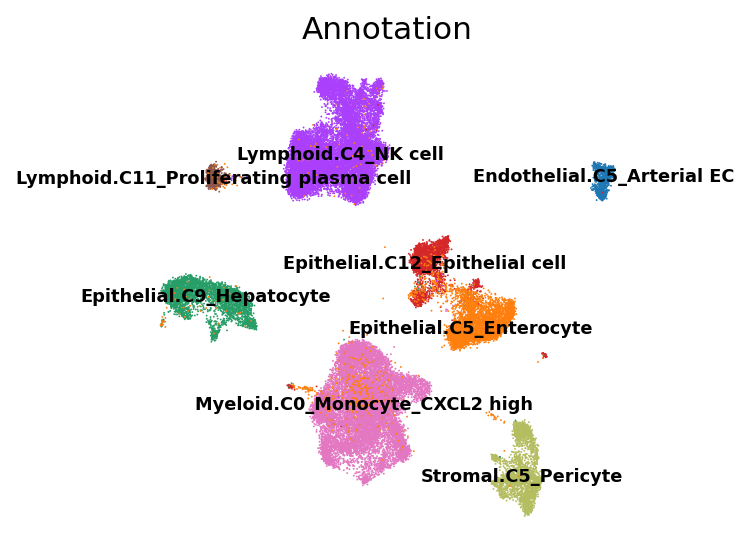

In [28]:
sc.pl.umap(adata, color=['Annotation'], frameon=False, legend_loc='on data', legend_fontsize=8)

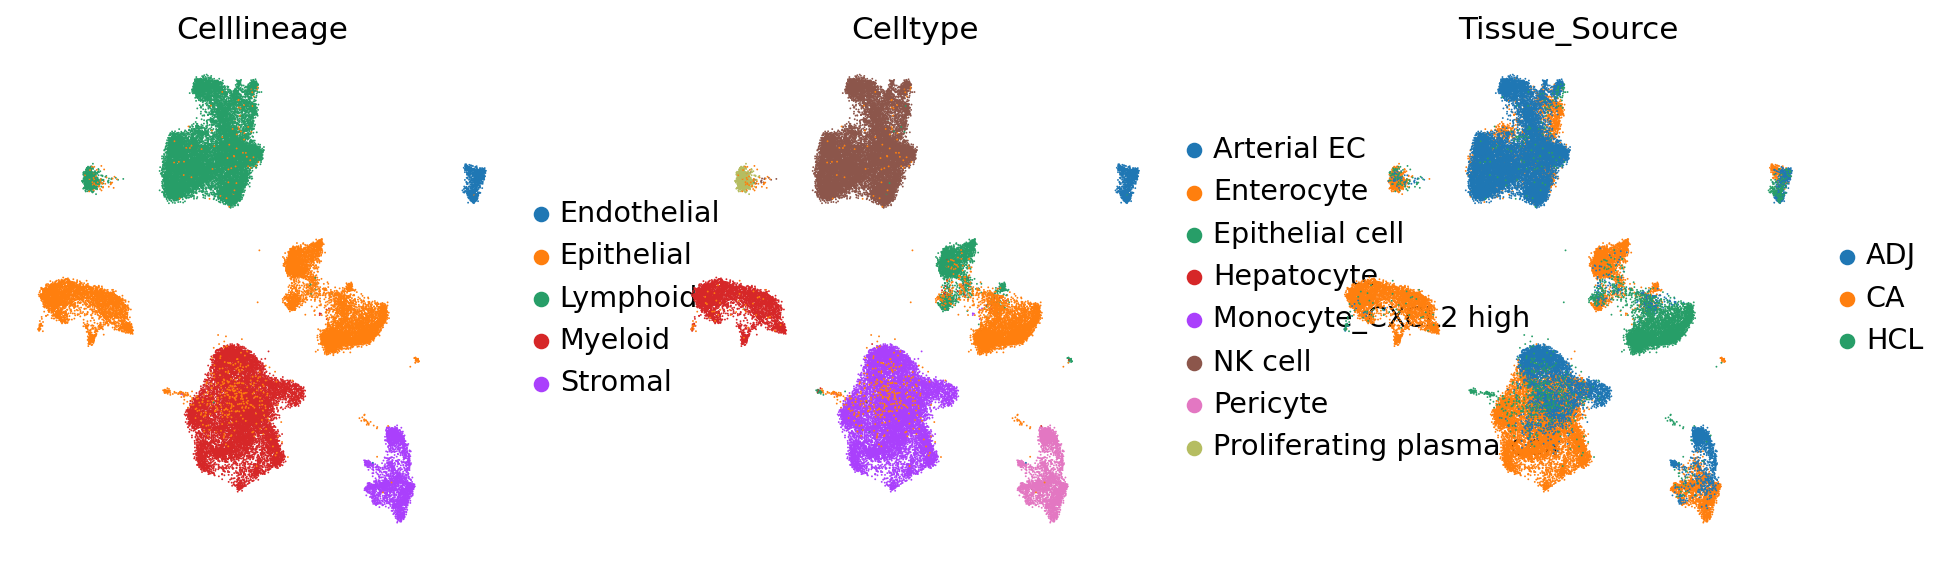

In [51]:
sc.pl.umap(adata, color=['Celllineage', 'Celltype', 'Tissue_Source'], frameon=False)

# Load query data for predict mapping

In [38]:
adata_predict = '../example/adata_predict.h5ad'
adata_predict_output = '../example/adata_predict_gmt.h5ad'

In [39]:
predict = sc.read(adata_predict)

In [40]:
predict = predict[:, predict.var_names & adata.var_names].copy()
df_predict = pd.DataFrame.sparse.from_spmatrix(predict.X, columns = predict.var_names, index = predict.obs_names)
df_predictadd = pd.DataFrame(index = predict.obs.index, columns = adata.var_names.difference(predict.var_names))
df_predict = df_predict.merge(df_predictadd, left_index = True, right_index = True, how = 'left')
df_predict = df_predict.fillna(0)
df_predict = df_predict[adata.var_names]
predict = sc.AnnData(df_predict, obs = predict.obs)
predict.X = predict.X.astype('int32')
predict.layers["counts"] = predict.X.copy()
predict.obs['batch'] = 'Query'
predict.uns['terms'] = adata.uns['terms']

In [41]:
predict.write(adata_predict_output, compression = True)

# Initlizling the model for predict training

In [42]:
predict_dir = '../example/model_predict'

In [43]:
p_intr_cvae = sca.models.EXPIMAP.load_query_data(predict, intr_cvae)

AnnData object with n_obs × n_vars = 15867 × 8500
    obs: 'Cell', 'Sample_Name', 'Patient', 'Tumor', 'Tissue_Source', 'Tissue', 'Cluster', 'Celltype', 'Celllineage', 'Cellcluster', 'Annotation', 'batch'
    uns: 'terms'
    layers: 'counts'

INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 8500 512 3
	Hidden Layer 1 in/out: 512 512
	Hidden Layer 2 in/out: 512 512
	Hidden Layer 3 in/out: 512 512
	Hidden Layer 4 in/out: 512 512
	Mean/Var Layer in/out: 512 2000
Decoder Architecture:
	Masked linear layer in, ext_m, ext, cond, out:  2000 0 0 3 8500
	with hard mask.
Last Decoder layer: softmax


In [44]:
p_intr_cvae.train(n_epochs=500, 
                  alpha_epoch_anneal=130, 
                  weight_decay=0., 
                  alpha_kl=0.0001,
                  seed=2020, 
                  use_early_stopping=True,
                  print_n_deactive=True,
                  print_stats=True
                 )

 |████████------------| 44.2%  - val_loss: 828.2575918344 - val_recon_loss: 827.3763099084 - val_kl_loss: 8812.8498347356
ADJUSTED LR
 |█████████-----------| 45.6%  - val_loss: 831.4370492788 - val_recon_loss: 830.5557532677 - val_kl_loss: 8812.9175931490
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 206


In [45]:
p_intr_cvae.save(predict_dir)

### Get latent representation of predict data

In [46]:
MEAN = False

In [47]:
predict.obsm['X_cvae'] = p_intr_cvae.get_latent(mean=MEAN, only_active=True)

In [48]:
sc.pp.neighbors(predict, use_rep='X_cvae')
sc.tl.umap(predict)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:11)


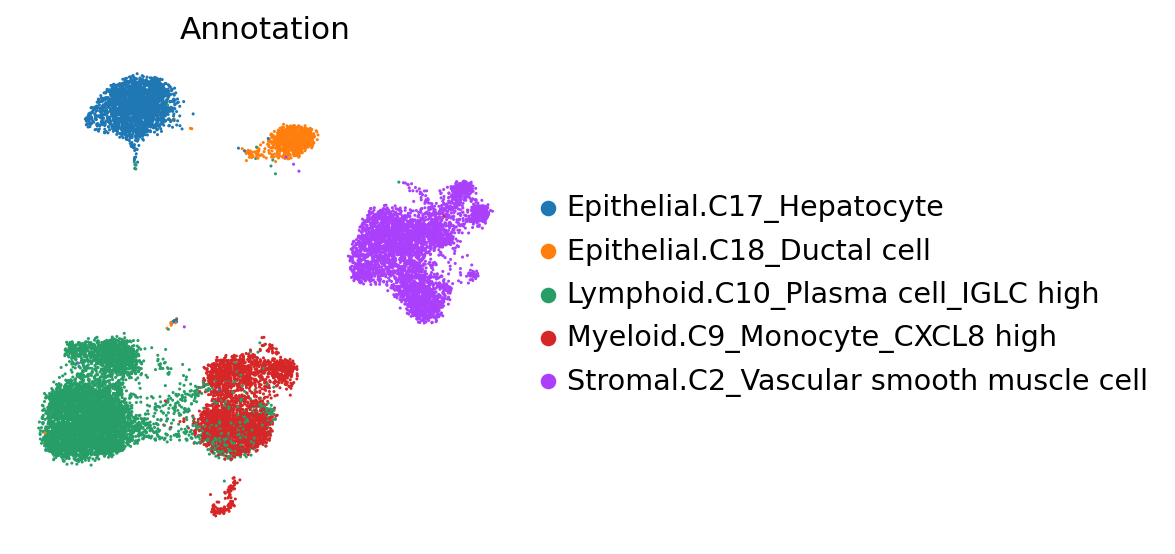

In [55]:
sc.pl.umap(predict, color=['Annotation'], frameon=False)

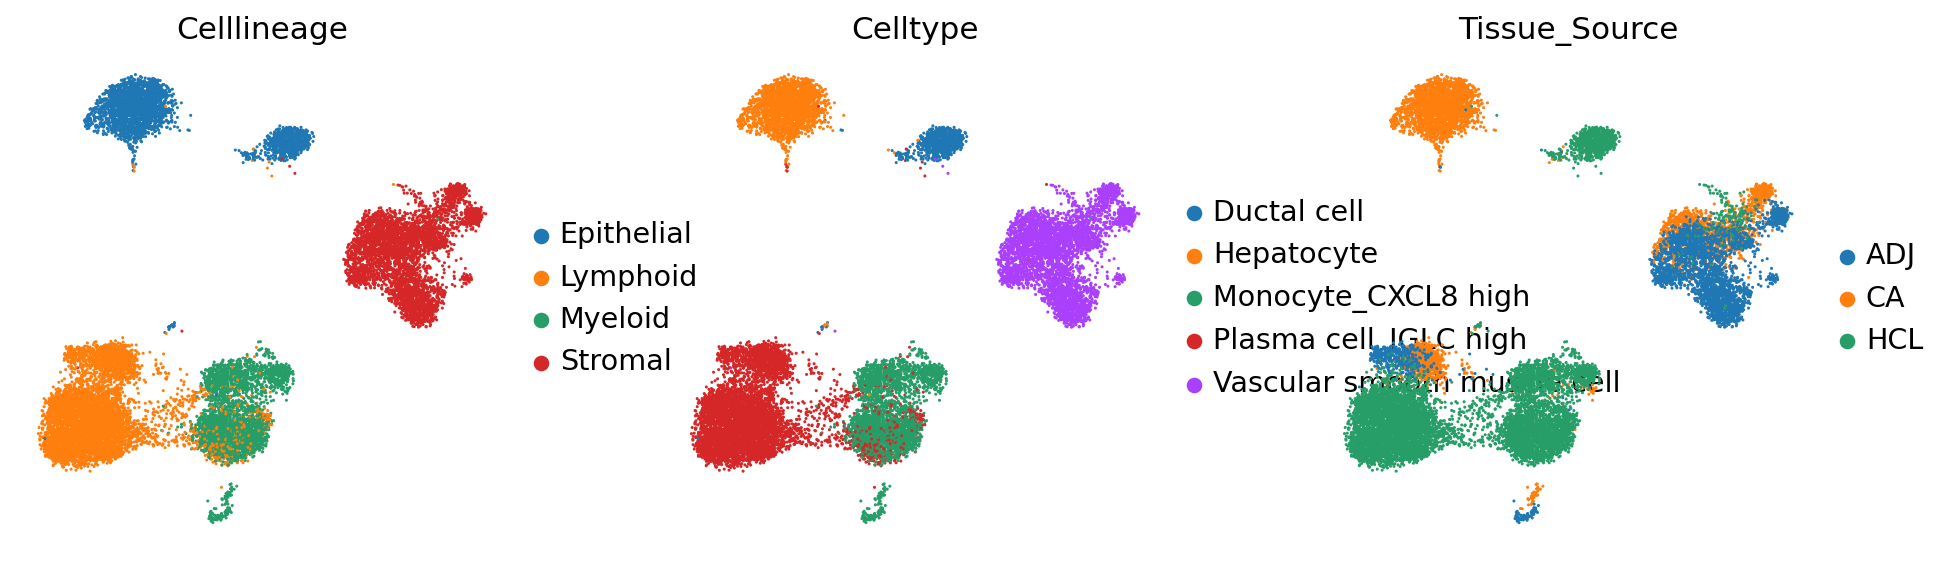

In [56]:
sc.pl.umap(predict, color=['Celllineage', 'Celltype', 'Tissue_Source'], frameon=False)

# Get latent representation of train + predict data

In [57]:
predict_pbmc = sc.AnnData.concatenate(adata, predict, batch_key='batch_join', uns_merge='same')

In [58]:
predict_pbmc.obsm['X_cvae'] = p_intr_cvae.get_latent(predict_pbmc.X, 
                                                   predict_pbmc.obs['Tissue_Source'], 
                                                   mean=MEAN, 
                                                   only_active=True)

In [59]:
sc.pp.neighbors(predict_pbmc, use_rep='X_cvae')
sc.tl.umap(predict_pbmc)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:12)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:45)


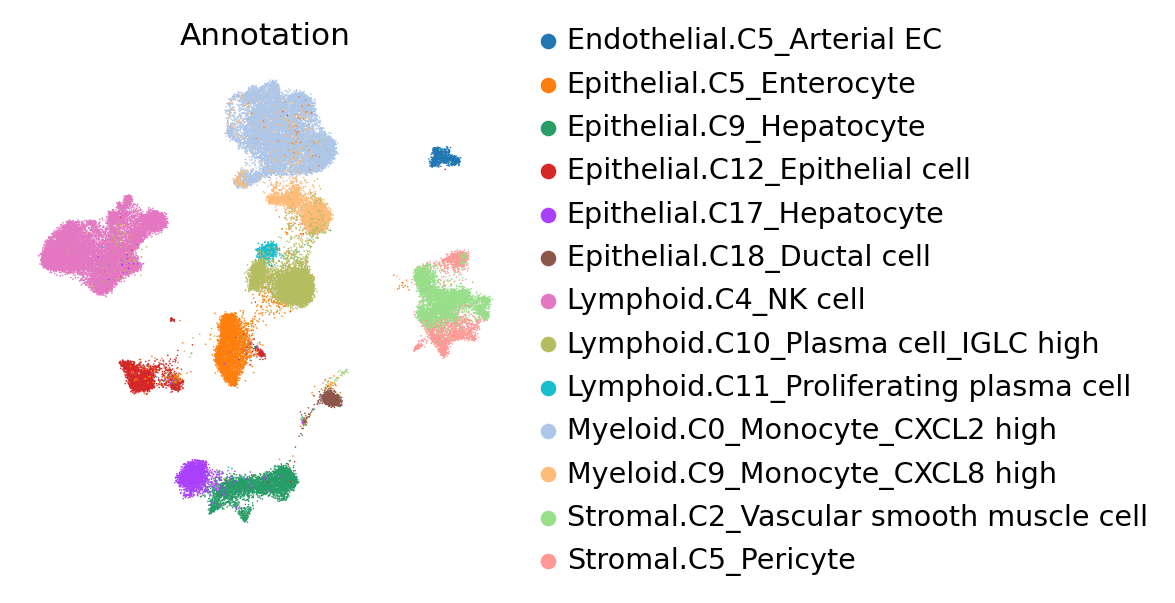

In [64]:
sc.pl.umap(predict_pbmc, color=['Annotation'], frameon=False)

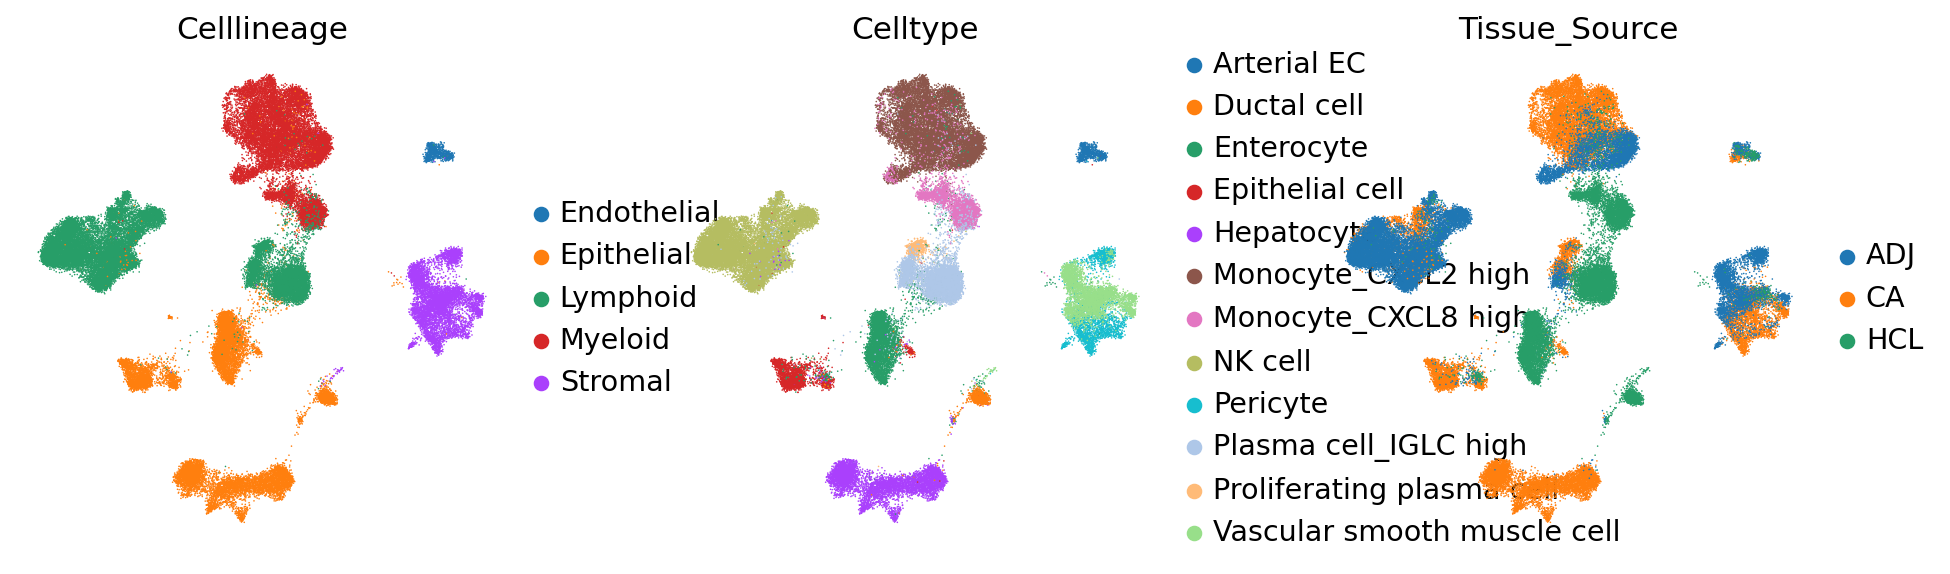

In [65]:
sc.pl.umap(predict_pbmc, color=['Celllineage', 'Celltype', 'Tissue_Source'], frameon=False)

Calculate directions of upregulation for each latent score and put them to .uns['directions'].

In [66]:
p_intr_cvae.latent_directions(adata = predict_pbmc)

Do gene set enrichment test for condition in reference + query using Bayes Factors.

In [67]:
p_intr_cvae.latent_enrich(groups='Cellcluster', comparison='rest', use_directions=True, adata=predict_pbmc)

In [70]:
sc.set_figure_params(figsize=(16, 30))

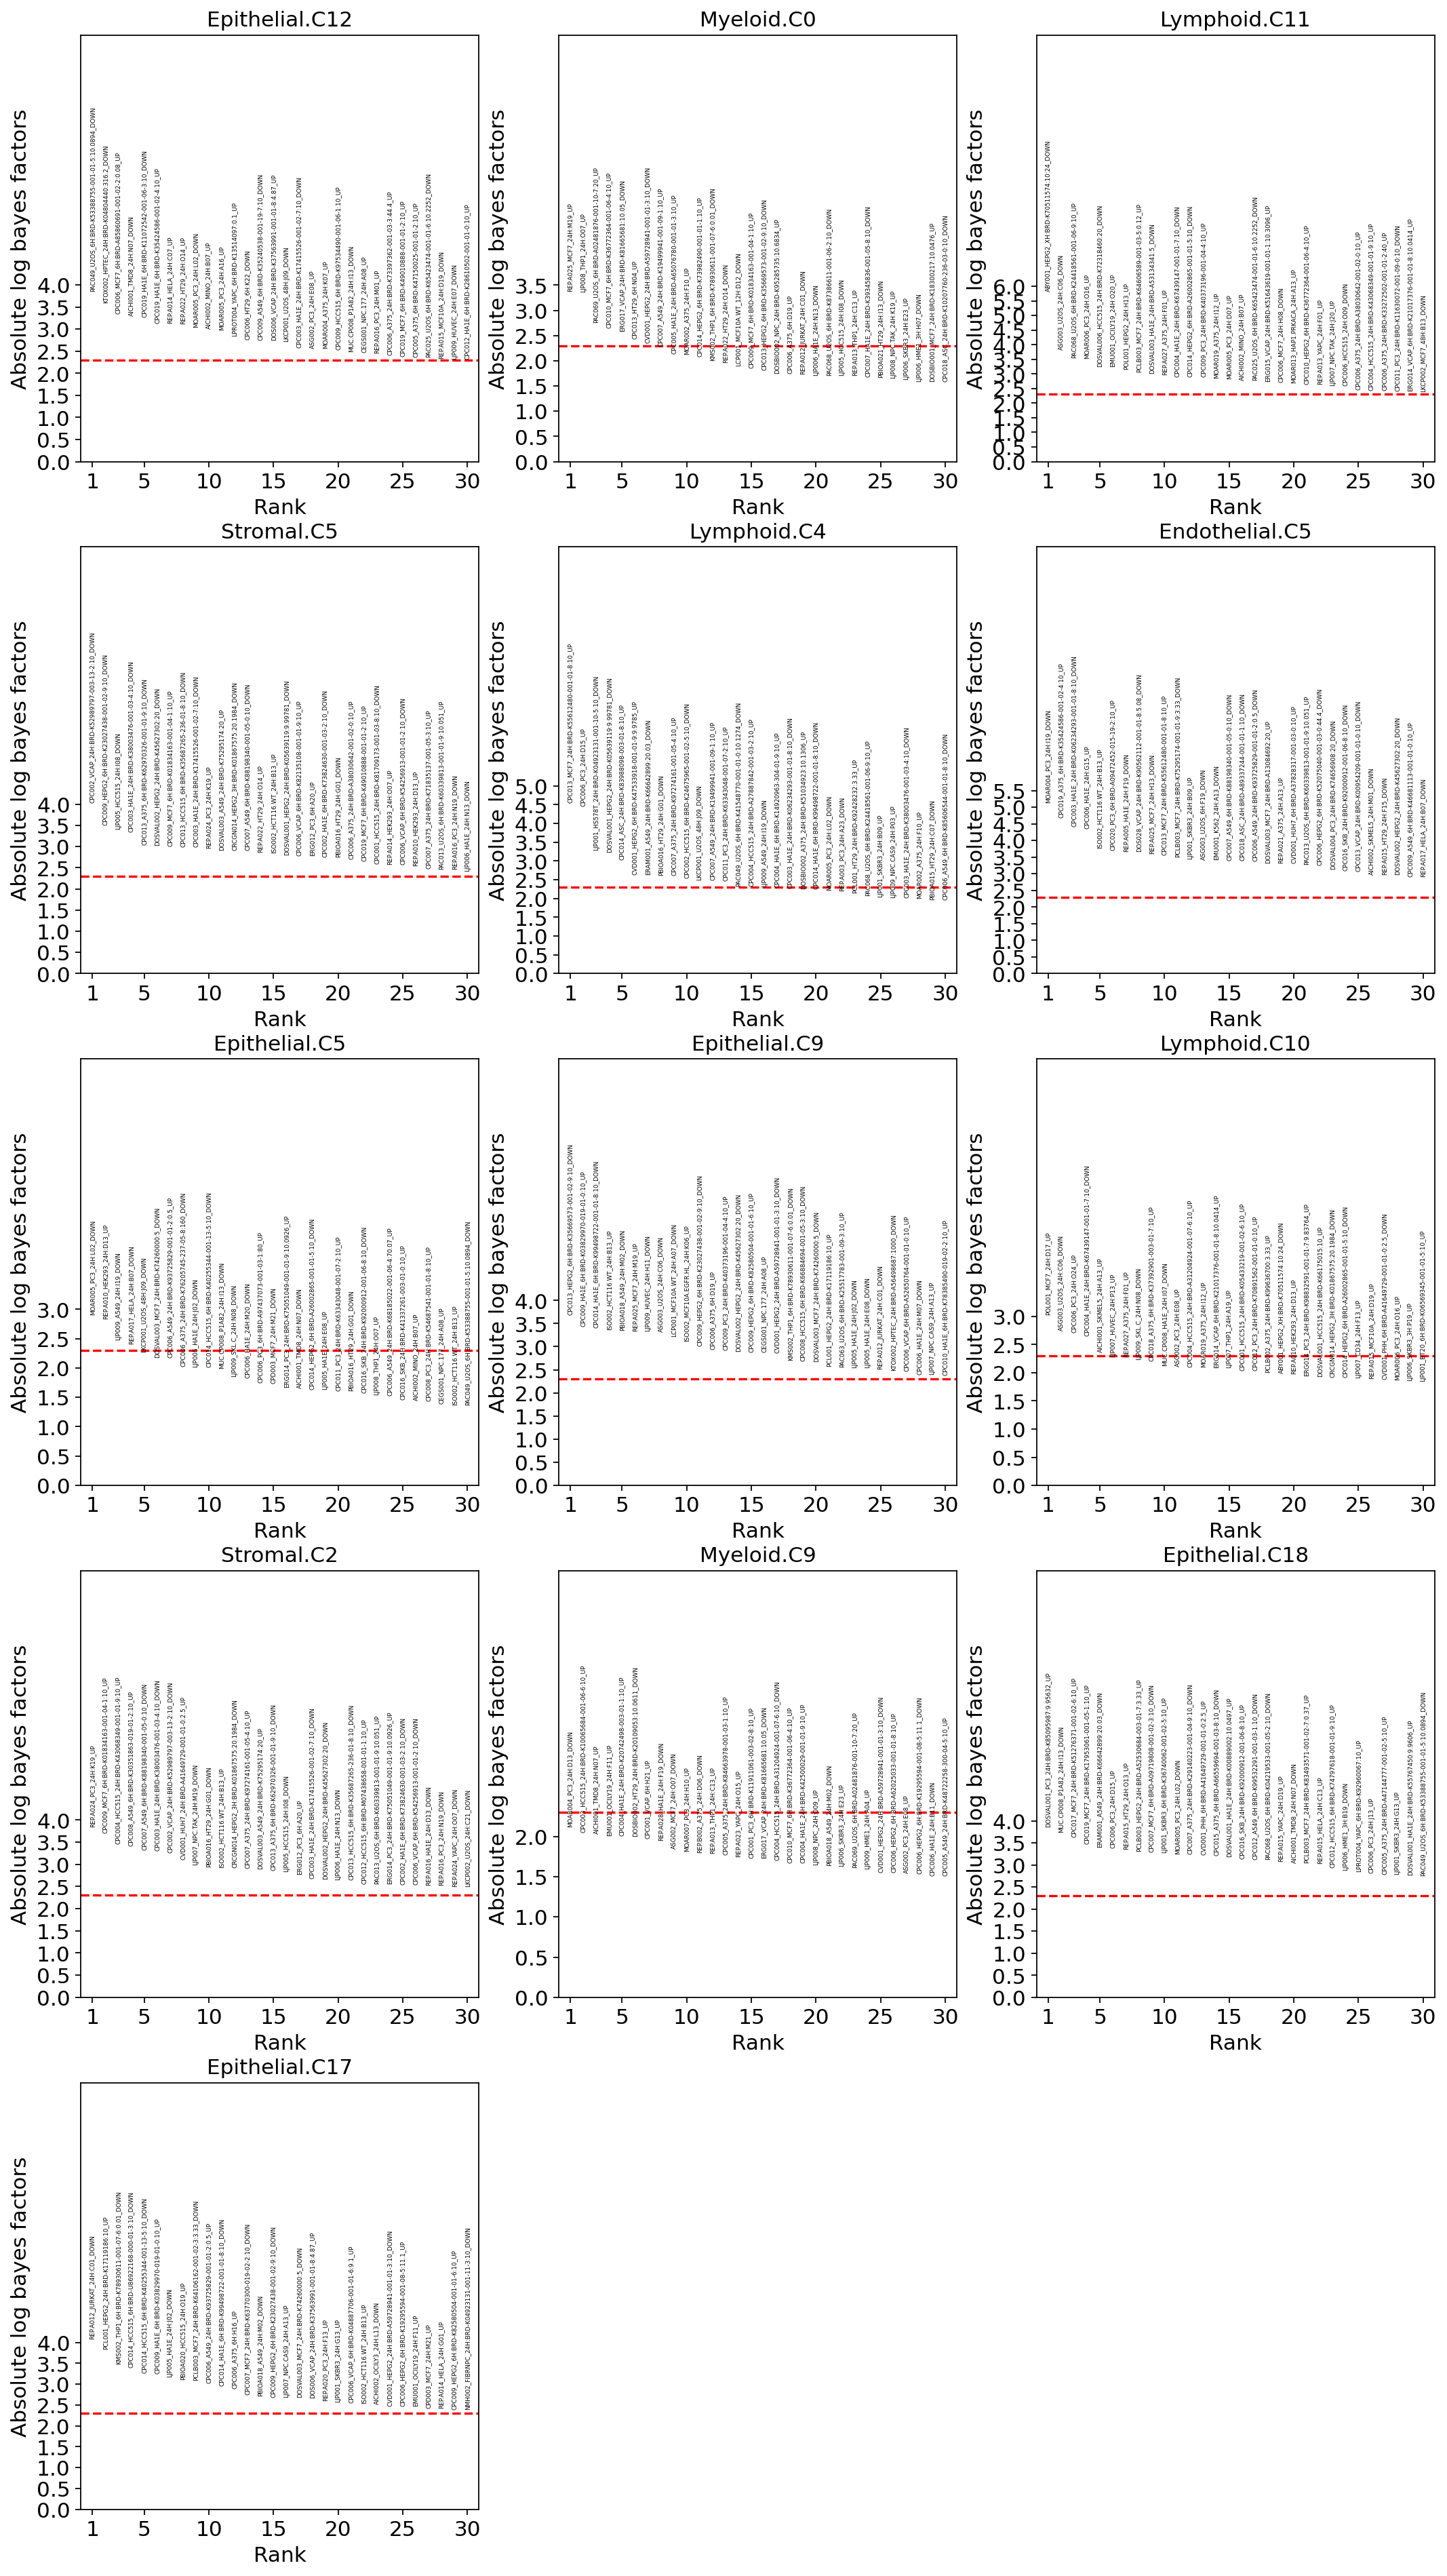

In [71]:
fig = sca.plotting.plot_abs_bfs(predict_pbmc, yt_step=0.5, scale_y=2.5, fontsize=4)

### Plot the latent variables for train + predict data corresponding to the terms

Focus on epithelial.C12, PAC049_U2OS_6H:BRD-K53388755-001-01-5:10.0894_DOWN is the top terms compared to other cells.

In [95]:
sc.set_figure_params(figsize=(6, 6))

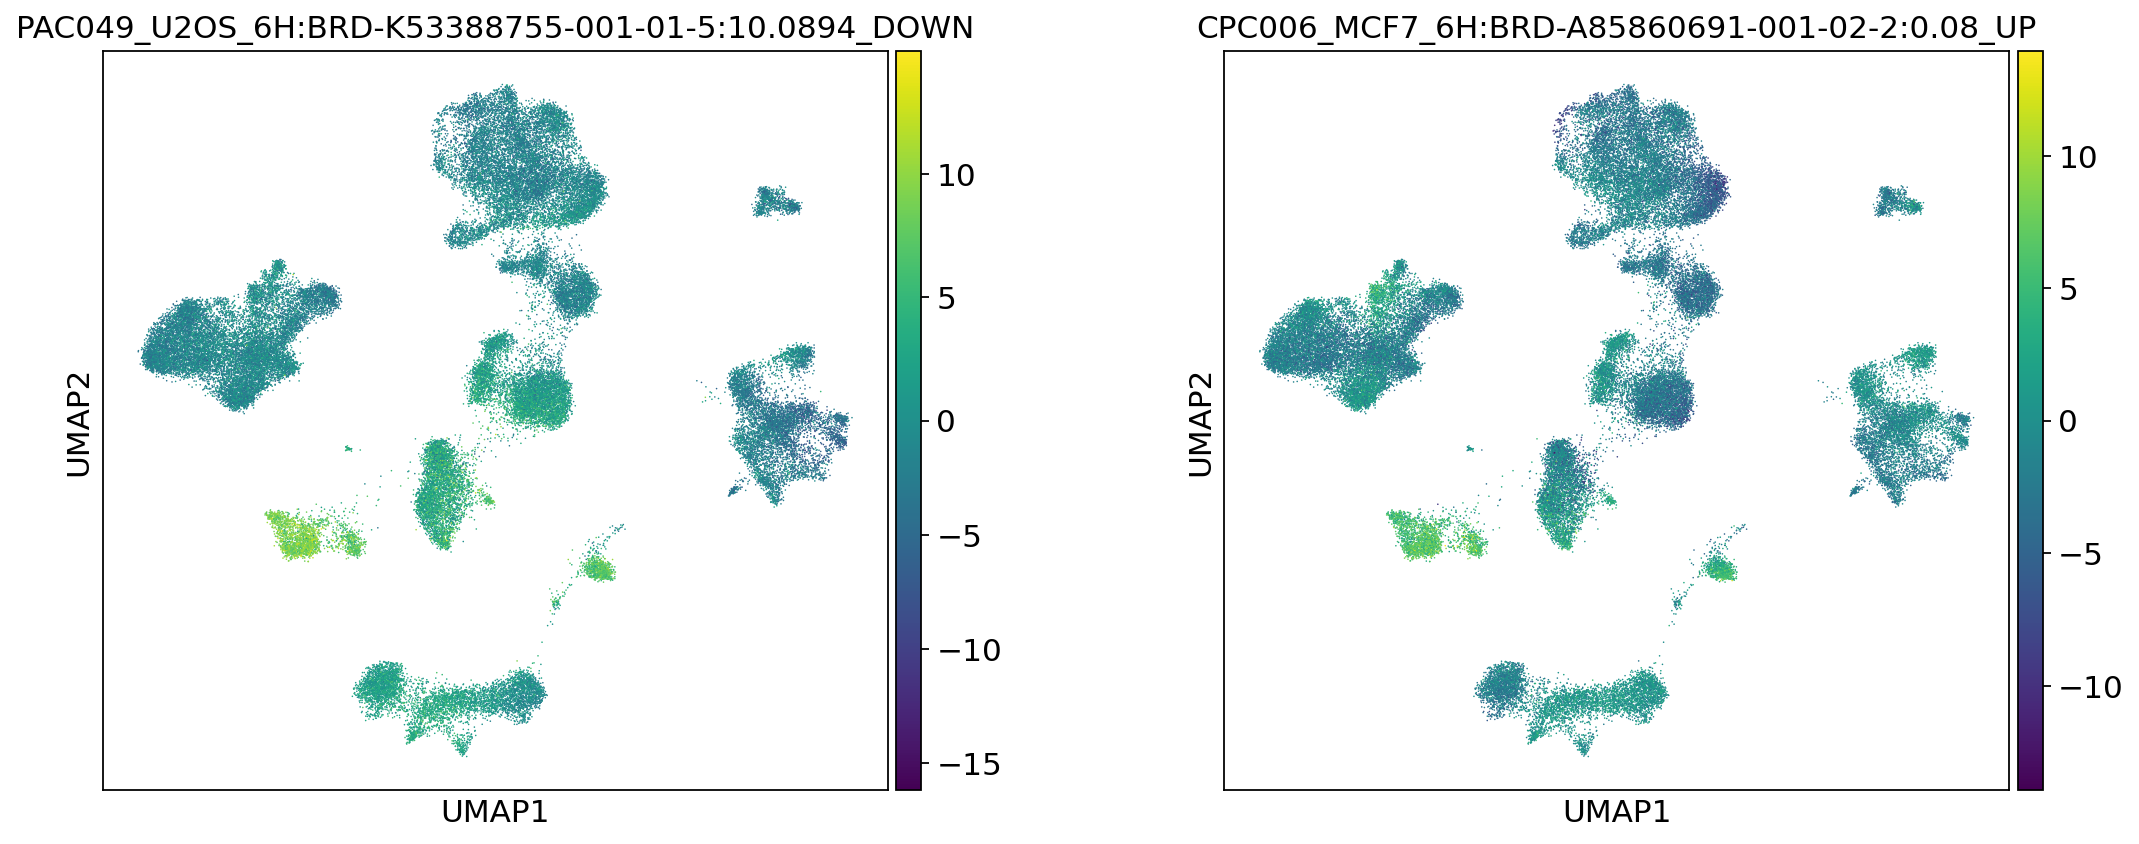

In [98]:
sc.pl.umap(predict_pbmc, color=['PAC049_U2OS_6H:BRD-K53388755-001-01-5:10.0894_DOWN',
                               'CPC006_MCF7_6H:BRD-A85860691-001-02-2:0.08_UP'],
           cmap='viridis', vcenter=0, wspace=0.3, sort_order=False)

In [88]:
terms = predict_pbmc.uns['terms']
select_terms = ['PAC049_U2OS_6H:BRD-K53388755-001-01-5:10.0894_DOWN', 
                'CPC006_MCF7_6H:BRD-A85860691-001-02-2:0.08_UP']
idx = [terms.index(term) for term in select_terms]

Multiplying the latent varibales by the calculated directons to ensure positive latent scores corresponf to upregulation.

In [89]:
latents = (p_intr_cvae.get_latent(predict_pbmc.X, predict_pbmc.obs['Tissue_Source'], mean=MEAN) * predict_pbmc.uns['directions'])

In [90]:
latents_sub = latents[:, idx]

In [94]:
predict_pbmc.obs['PAC049_U2OS_6H:BRD-K53388755-001-01-5:10.0894_DOWN'] = latents_sub[:, 0]
predict_pbmc.obs['CPC006_MCF7_6H:BRD-A85860691-001-02-2:0.08_UP'] = latents_sub[:, 1]

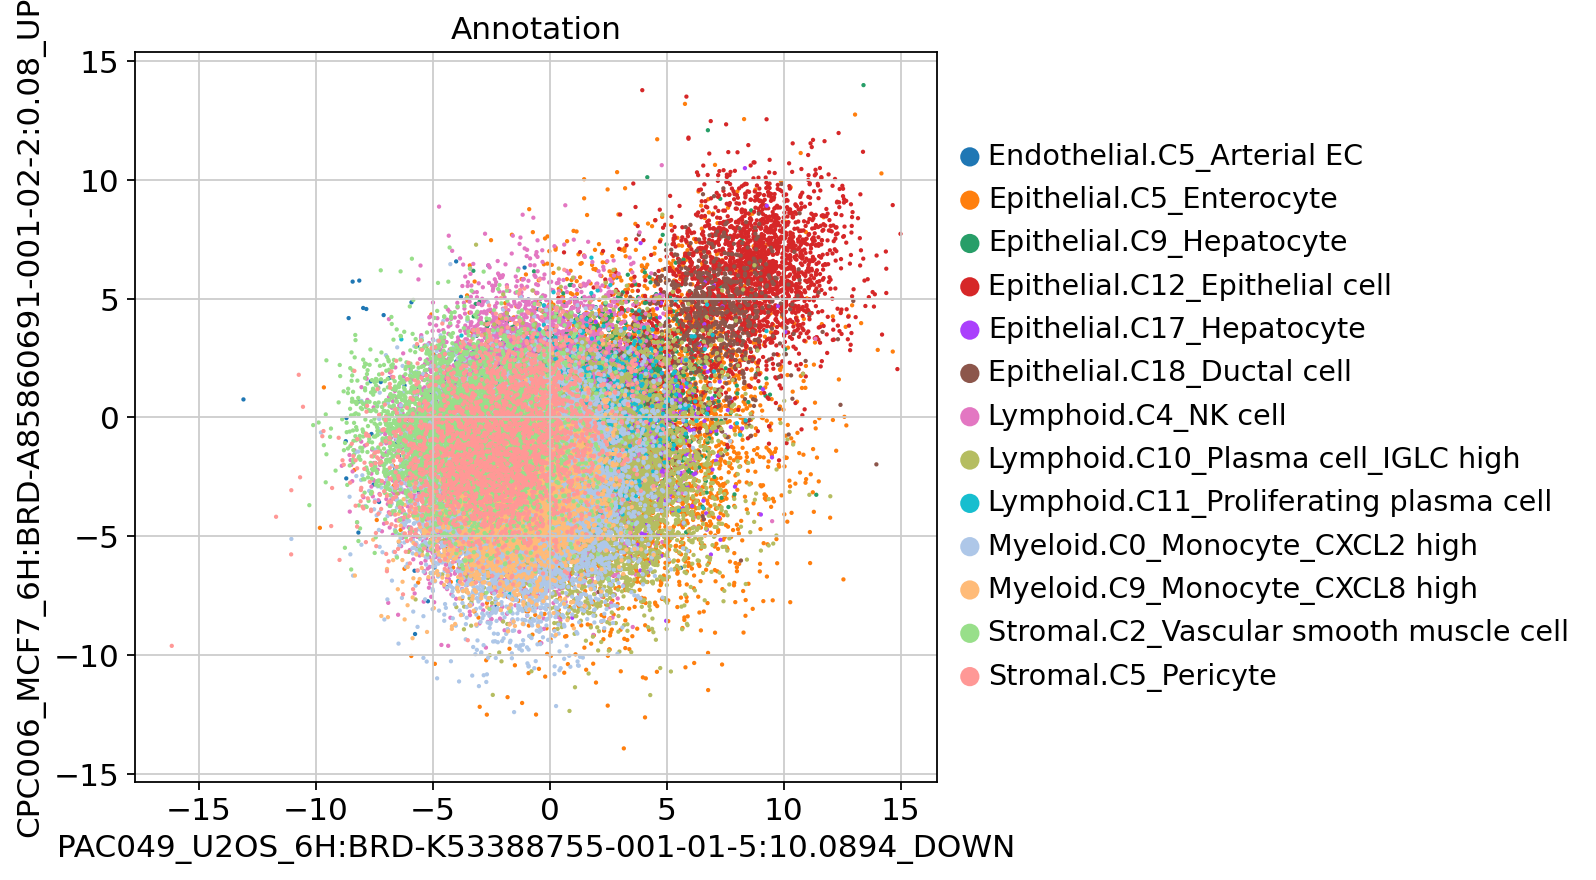

In [99]:
sc.pl.scatter(predict_pbmc, x='PAC049_U2OS_6H:BRD-K53388755-001-01-5:10.0894_DOWN',
              y='CPC006_MCF7_6H:BRD-A85860691-001-02-2:0.08_UP', color='Annotation', size=15, 
              title = 'Annotation' )